## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [222]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [223]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [224]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [225]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [226]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [227]:
converted = df.query('converted == 1').user_id.nunique() / df.user_id.nunique()
converted

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [228]:
# Here we see when new page cell doesn't match with treatment cell
mismatch_1 = df.query('landing_page == "new_page" and group != "treatment"').user_id.count() 
mismatch_2 = df.query('group == "treatment" and landing_page != "new_page"').user_id.count()

mismatch = mismatch_1 + mismatch_2
mismatch

3893

f. Do any of the rows have missing values?

In [229]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [230]:
# Now, we separate each group with its corresponding page
tr_ng = df.query('group == "treatment" and landing_page == "new_page"') 
cr_op = df.query('group == "control" and landing_page == "old_page"')
df2 = tr_ng.append(cr_op)

In [231]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [232]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [233]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [234]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [235]:
df2 = df2.drop(2893)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [236]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [237]:
control_converted = df2.query('group == "control"').converted.mean()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [238]:
Treatment_converted = df2.query('group == "treatment"').converted.mean()
Treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [239]:
df2.query('landing_page == "new_page"').shape[0] / df2.user_id.shape[0] 

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [240]:
obs_diff = Treatment_converted - control_converted
obs_diff

-0.0015782389853555567

**This little value for the difference between people who converted from old page (12.04%) and new page (11.88%)  doesn't show sufficient evidence that the new page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

## Null hypothes (Ho): **$p_{new}$** <= **$p_{old}$**  
## Alternative hypothesis (H1): **$p_{new}$** > **$p_{old}$**  

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [241]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [242]:
# AS (𝑝𝑛𝑒𝑤)  and  (𝑝𝑜𝑙𝑑) both have "true" success 
#rates equal to the converted success rate regardless of page
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [243]:
#Number of people who experienced the new page
n_new = df2[df2.group == "treatment"].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [244]:
#Number of people who experienced the old page
n_old = df2[df2.group == "control"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [245]:
new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [246]:
old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [247]:
new_page_converted.mean() - old_page_converted.mean()

-0.00097233872846715086

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [248]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old, p_old])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

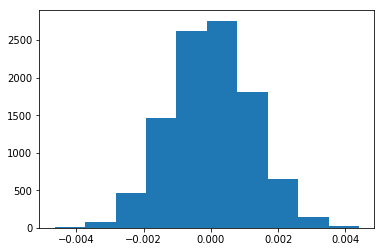

In [249]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [250]:
(p_diffs > obs_diff).mean()

0.90180000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This value of (0.9) represents the P-value -which shall be more than alpha in this case (.05) to fail to reject the null hypothesis-.**
**Apparently, our value is bigger than Alpha so we fail to reject the null and the new page doesn't appear to attract more people to convert**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [251]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted = =1').shape[0]
convert_new = df2.query('group == "treatment" & converted = =1').shape[0]
n_old = df2[df2.group == "control"].shape[0]
n_new = df2[df2.group == "treatment"].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [252]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**For the p_value equals to (0.90), it means that we fail to reject the null and the new page isn't useful**

**For alpha = .05 and confidence interval = 95%, Z_score is between (-1.96, 1.96). Here we have z_score of (-1.31) which indicates -with p_value of (0.905) that we could not reject the null.**  

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [253]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [254]:
lg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [255]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-13 21:29 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [256]:
1/np.exp(result.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**p_value = (0.1899) is larger than (0.05) so we fail to reject the null**

**P_value is different in Part2 from part3 because of the assumptions of the null and alternative hypotheses**

## Part 2
### Null hypothes (Ho):  𝑝𝑛𝑒𝑤  <=  𝑝𝑜𝑙𝑑 
### Alternative hypothesis (H1):  𝑝𝑛𝑒𝑤  >  𝑝𝑜𝑙𝑑

## Part 3
### Null hypothes (Ho):  𝑝𝑛𝑒𝑤  =  𝑝𝑜𝑙𝑑 
### Alternative hypothesis (H1):  𝑝𝑛𝑒𝑤  !=  𝑝𝑜𝑙𝑑

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There are many things to consider that may affect our results. We can use age, prices, standard of living, profession.**

**These additional terms may show opposite results so it would be hard to know which is the most important characteristic to use.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [257]:
country = pd.read_csv('countries.csv')
country.shape

(290584, 2)

In [258]:
merged_df = pd.merge(df2, country, on = 'user_id')
merged_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA


In [259]:
countries_dum = pd.get_dummies(merged_df.country)
df2_dum = merged_df.join(countries_dum) 
df2_dum.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0


In [260]:
lg = sm.Logit(df2_dum['converted'], df2_dum[['intercept', 'ab_page', 'US', 'UK']])
result = lg.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [261]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-13 21:30 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [262]:
1/np.exp(result.params)

intercept    7.614303
ab_page      1.015056
US           0.960062
UK           0.950621
dtype: float64

**These results (0.96, 0.95) shows no significant effect of country on conversion rate.** 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [263]:
df2_dum['US_page'] = df2_dum['ab_page'] * df2_dum['US']
df2_dum['UK_page'] = df2_dum['ab_page'] * df2_dum['UK']
df2_dum.head()                                             

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,US_page,UK_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,1,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,1,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0,0,0


In [264]:
lg = sm.Logit(df2_dum['converted'], df2_dum[['intercept', 'ab_page', 'US', 'UK', 'US_page','UK_page']])
result = lg.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [265]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-13 21:30 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

In [266]:
1/np.exp(result.params)

intercept    7.418713
ab_page      1.069775
US           0.982625
UK           0.988285
US_page      0.954198
UK_page      0.924703
dtype: float64

**These results shows no significant effect of page on different countries.** 

<a id='conclusions'></a>
## Conclusion

- By using AB test, Regression and propabilty, we can conclude that the new page has no super power to attract more people to convert.

- We shall use the same old page or try another new page or features to have higher conversion rate. 
 


In [267]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0